# CNN 활용 보행자 검출

### import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


### 학습한 모델 파일 Load

In [2]:
model = load_model('dpcnn.h5')

### 128 x 64 크기 16 step으로 탐색

In [3]:
hroi = 128
wroi = 64
step = 16

image = cv2.imread('pedestrian_test.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

guide_img = np.zeros((image.shape[0],image.shape[1],3), np.uint8)
detect_img = np.zeros((image.shape[0],image.shape[1],3), np.uint8)
heatmap  = np.zeros_like(image[:,:,0]).astype(np.float)

wroi_count = (image.shape[1] - wroi) // step
hroi_count = (image.shape[0] - hroi) // step

for i in range(wroi_count):
    startx = i * step
    endx = wroi + i * step
    for j in range(hroi_count):
        # 128 x 64 이미지를 16step 돌면서 탐색
        starty = j * step
        endy = hroi + j * step
        # 관심영역 지정 후 predict 실행
        roi = image[starty:endy, startx:endx]        
        Y_hats = model.predict(np.array([roi,]))
        y_hats = Y_hats.argmax(axis=-1)
        test_prediction = y_hats[0]
        
        # Grid 표시
        cv2.rectangle(guide_img, (startx, starty), (endx, endy), (0,255,0), 1)   
        
        # predict 성공 시 Grid 표시, Heatmap list
        if test_prediction == 1:            
            cv2.rectangle(detect_img, (startx, starty), (endx, endy), (255,0, 0), 2)   
            heatmap[starty:endy, startx:endx] += 1

### 가이드 이미지 출력

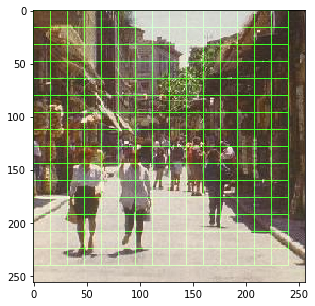

In [4]:
added_img = cv2.addWeighted(image, 1, guide_img, 1, 0)
plt.figure(figsize = (5,5))
plt.imshow(added_img)

### predict 된 이미지 구간 Grid 표시

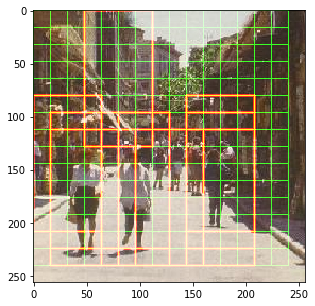

In [5]:
added_img = cv2.addWeighted(added_img, 1, detect_img, 1, 0)
plt.figure(figsize = (5,5))
plt.imshow(added_img)

### predict 된 이미지 구간 Heatmap 표시

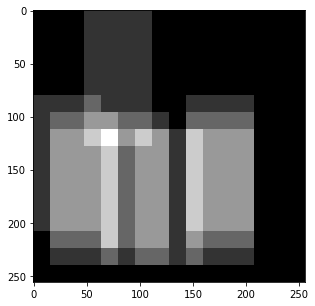

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(heatmap, cmap='gray')

### 1보다 작은 값은 0으로 변환

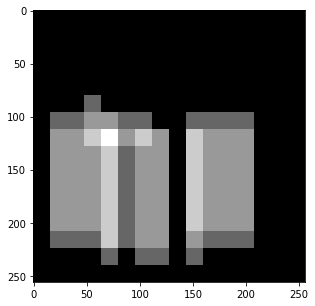

In [7]:
heatmap[heatmap <= 1] = 0
plt.figure(figsize = (5,5))
plt.imshow(heatmap, cmap='gray')

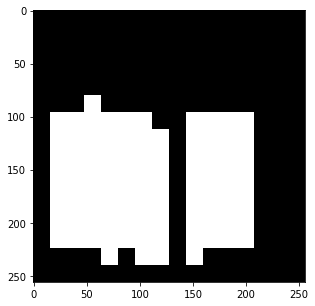

In [8]:
heatmap = np.clip(heatmap, 0, 1)
plt.figure(figsize = (5,5))
plt.imshow(heatmap, cmap='gray')

### 라벨링 : 도형을 구분하고 갯수 확인

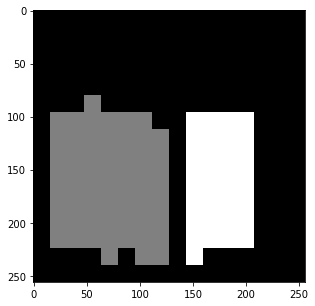

In [9]:
from scipy.ndimage.measurements import label
labels = label(heatmap)
plt.figure(figsize = (5,5))
plt.imshow(labels[0], cmap='gray')

### 이미지에 라벨들을 rectangle 로 표시

In [10]:
def draw_labeled_bboxes(img, labels):
    box_list = []
    
    # Iterate through all detected cars
    for index in range(1, labels[1]+1):
        # Find pixels with each index label value
        nonzero = (labels[0] == index).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # could be [0,255] or [0,1] depending how the file was read in
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
        
        box_list.append(bbox)

    return img, box_list

### 라벨 결과 이미지

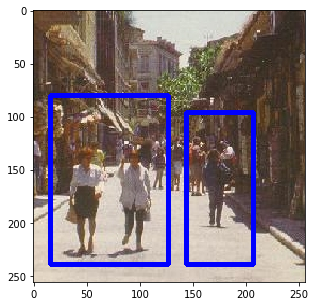

In [11]:
result_img, box_list = draw_labeled_bboxes(image, labels)
plt.figure(figsize = (5,5))
plt.imshow(result_img)